
# Audio PreProcessing 
# **Authors**: [José Antonio Ruiz Heredia](josrui05@ucm.es) [Néstor Marín Gómez](nestorma@ucm.es)


In [86]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import os
import sounddevice as sd
from Constants.DataPaths import *



Select an original audio and their respective forgeries to try and compare the different pre processing.

In [3]:
# Select a random audio from the original dataset
def select_random_audio(original_path):
    archives = os.listdir(original_path)
    
    if not archives:
        return None
    
    # Select a random audio from the original folder
    random_index = random.randint(0,len(archives)-1)
    random_audio = archives[random_index]
    
    # Build the path to the selected audio
    audio_path = os.path.join(original_path, random_audio)
    
    # Name without the extension
    audio_name = os.path.splitext(random_audio)[0]
    
    return random_audio, audio_name, audio_path


# Search the forgered audios based on the original audio name
def search_forgered_audio(path, audio_name):
    files_found = []
    files = os.listdir(path)
    
    for file in files:
        if file.startswith(audio_name) and "_" in file:
            files_found.append(os.path.join(path, file))
            
    return files_found

    
def select_audios(files_found_splicing, files_found_copy_move):
    # Select random index
    random_index = random.randint(0,min(len(files_found_splicing)-1,len(files_found_copy_move)-1))
    
    # Take the random audios from the list of forgered audios matching the original audio
    random_audio_splicing = files_found_splicing[random_index]
    random_audio_cm = files_found_copy_move[random_index]
    
    return random_audio_splicing, random_audio_cm


Show the ``selected audios`` randomly choosen.

In [4]:
selected_audio_path, audio_name, audio_path = select_random_audio(ORIGINAL_DATASET_PATH)

if selected_audio_path is not None:
    print(f"Audio seleccionado: {audio_path}")
else:
    print("La carpeta está vacía.")

files_found_splicing = search_forgered_audio(SPLICING_DATASET_PATH, audio_name)
files_found_copy_move = search_forgered_audio(COPY_MOVE_DATASET_PATH, audio_name)
audio_splicing, audio_copy_move = select_audios(files_found_splicing, files_found_copy_move)

print(f"Audio respectivo con splicing: {audio_splicing}")
print(f"Audio respectivo con copy-move: {audio_copy_move}")

Audio seleccionado: C:/Users/rayma/Documents/Proyectos VSCode/Proyectos Python/DatasetConcatenation/OriginalDataset\SI1525.WAV
Audio respectivo con splicing: C:/Users/rayma/Documents/Proyectos VSCode/Proyectos Python/DatasetConcatenation/SplicingDataset\SI1525_4.WAV
Audio respectivo con copy-move: C:/Users/rayma/Documents/Proyectos VSCode/Proyectos Python/DatasetConcatenation/CopyMoveDataset\SI1525_4.WAV


In [5]:
from IPython.display import Audio
from matplotlib.patches import Rectangle


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

## Spectrogram

Load the different audios using torchaudio.




In [35]:
# Load audios
SPEECH_WAVEFORM_ORIGINAL, SAMPLE_RATE_ORIGINAL = torchaudio.load(audio_path)
SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING = torchaudio.load(audio_splicing)
SPEECH_WAVEFORM_COPY_MOVE, SAMPLE_RATE_COPY_MOVE = torchaudio.load(audio_copy_move)

# Define transform
spectrogram = T.Spectrogram(n_fft=1024, hop_length=128)

# Perform transforms
spec_original = spectrogram(SPEECH_WAVEFORM_ORIGINAL)
spec_splicing = spectrogram(SPEECH_WAVEFORM_SPLICING)
spec_copy_move = spectrogram(SPEECH_WAVEFORM_COPY_MOVE)

Create subplots using ``waveform`` and ``spectogram`` for each audio selected.

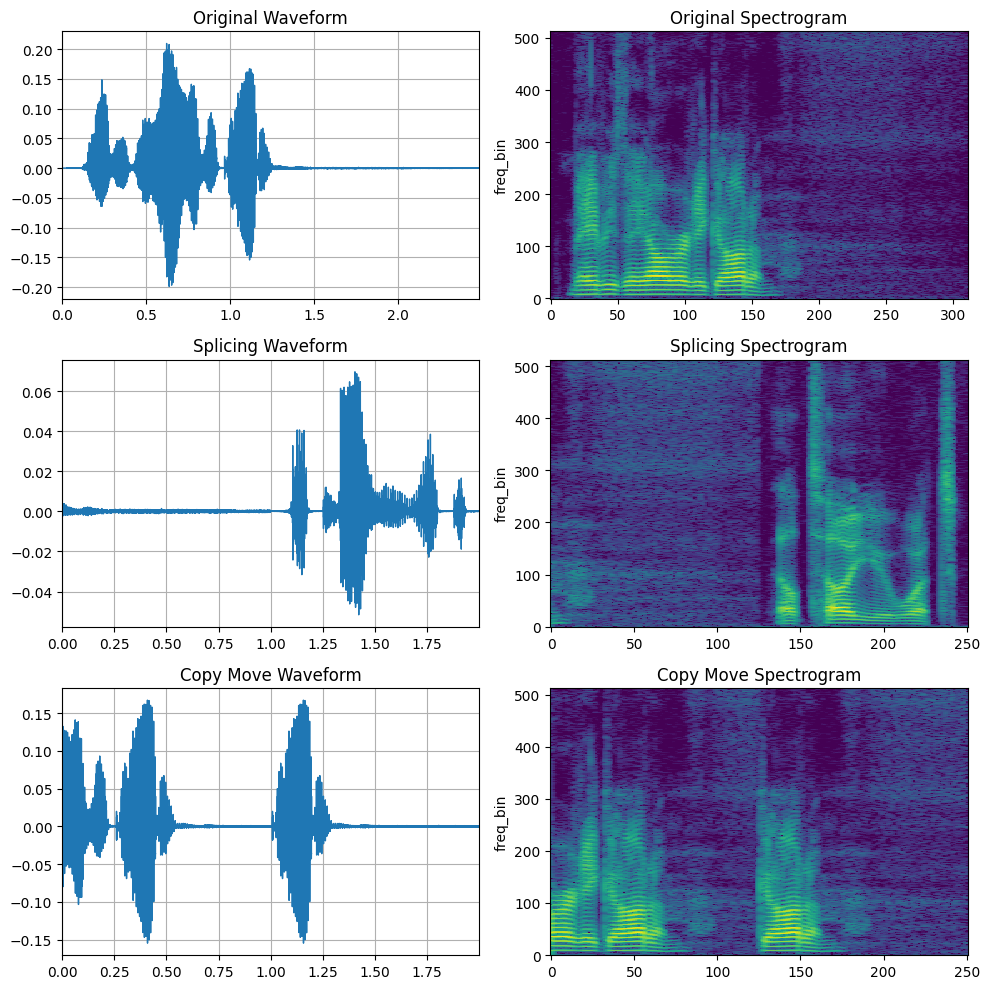

In [54]:
# Create a figure and axes
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot ORIGINAL AUDIO
plot_waveform(SPEECH_WAVEFORM_ORIGINAL, SAMPLE_RATE_ORIGINAL, title="Original Waveform", ax=axs[0, 0])
plot_spectrogram(spec_original[0], title="Original Spectrogram", ax=axs[0, 1])

# Plot SPLICING AUDIO
plot_waveform(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING, title="Splicing Waveform", ax=axs[1, 0])
plot_spectrogram(spec_splicing[0], title="Splicing Spectrogram", ax=axs[1, 1])

# Plot COPY MOVE AUDIO
plot_waveform(SPEECH_WAVEFORM_COPY_MOVE, SAMPLE_RATE_COPY_MOVE, title="Copy Move Waveform", ax=axs[2, 0])
plot_spectrogram(spec_copy_move[0], title="Copy Move Spectrogram", ax=axs[2, 1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Listen to the different audios selected.

In [55]:
Audio(SPEECH_WAVEFORM_ORIGINAL.numpy(), rate=SAMPLE_RATE_ORIGINAL)

In [56]:
Audio(SPEECH_WAVEFORM_SPLICING.numpy(), rate=SAMPLE_RATE_SPLICING)

In [57]:

Audio(SPEECH_WAVEFORM_COPY_MOVE.numpy(), rate=SAMPLE_RATE_COPY_MOVE)

Lets try with modifying the ``sample rate`` parameter on the original audio. 

In [108]:
print("Original audio")
Audio(SPEECH_WAVEFORM_ORIGINAL.numpy(), rate=SAMPLE_RATE_ORIGINAL)


Original audio
16000


In [91]:
SAMPLE_RATES = [SAMPLE_RATE_ORIGINAL, 44100,22050,8000,16000] #add as many as wanted to test
resampled_audios = {}

for sr in SAMPLE_RATES: #trying with different sample rates
    resampled_audios[sr] = F.resample(SPEECH_WAVEFORM_ORIGINAL,SAMPLE_RATE_ORIGINAL,sr)


Takes a random sample rate, and plays the original sound using it as a ``sample_rate`` parameter

In [110]:
idx = random.randint(0,len(SAMPLE_RATES) -1)

sr = SAMPLE_RATES[idx]
print(f"The original sample rate is: {SAMPLE_RATE_ORIGINAL}")
print(f"Original audio with the new sample rate: {sr}")
Audio(SPEECH_WAVEFORM_ORIGINAL.numpy(), rate=sr)


The original sample rate is: 16000
Original audio with the new sample rate: 44100


### The effect of ``n_fft`` parameter

The core of spectrogram computation is (short-term) Fourier transform,
and the ``n_fft`` determines the resolution of frequency axis.
However, with the higher ``n_fft`` value, the energy will be distributed
among more bins, so when you visualize it, it might look more blurry,
even thought they are higher resolution.

We are going to study the spectogram of the splicing audio to determine with 
which value for ``n_fft`` we can tell the forgery better.




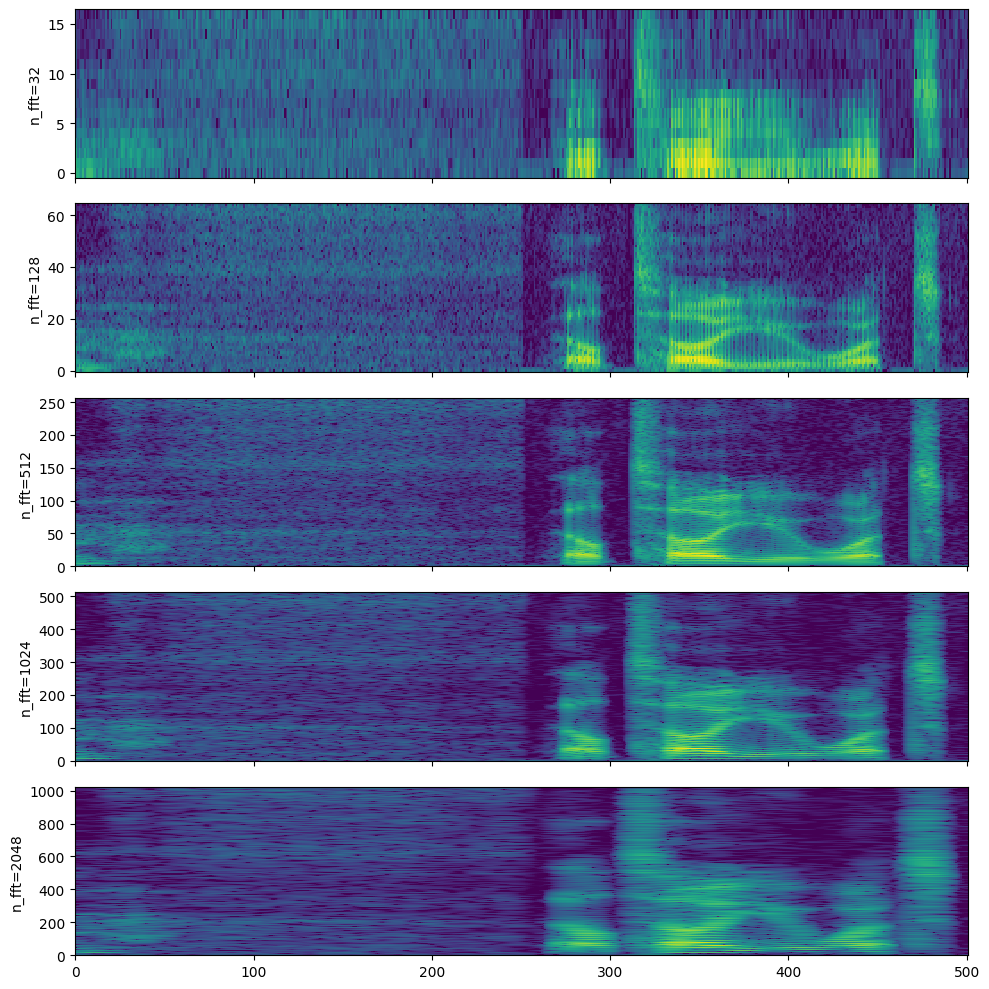

In [12]:
n_ffts = [32, 128, 512, 1024, 2048]
hop_length = 64

specs = []

for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec_test_n_fft = spectrogram(SPEECH_WAVEFORM_SPLICING)
    specs.append(spec_test_n_fft)

# Plot the same spectogram with different n_ffts values.
fig, axs = plt.subplots(len(specs), 1, figsize=(10, 10), sharex=True)

for i, (spec_test_n_fft, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec_test_n_fft[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
    
fig.tight_layout()

When comparing signals, it is desirable to use the same sampling rate,
however if you must use the different sampling rate, care must be
taken for interpretating the meaning of ``n_fft``.
Recall that ``n_fft`` determines the resolution of the frequency
axis for a given sampling rate. In other words, what each bin on
the frequency axis represents is subject to the sampling rate.

As we have seen above, changing the value of ``n_fft`` does not change
the coverage of frequency range for the same input signal.



Let's downsample the audio and apply spectrogram with the same ``n_fft``
value.



In [13]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING, SAMPLE_RATE_SPLICING // 2)

# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE_SPLICING // 2, SAMPLE_RATE_SPLICING)

In [14]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM_SPLICING)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

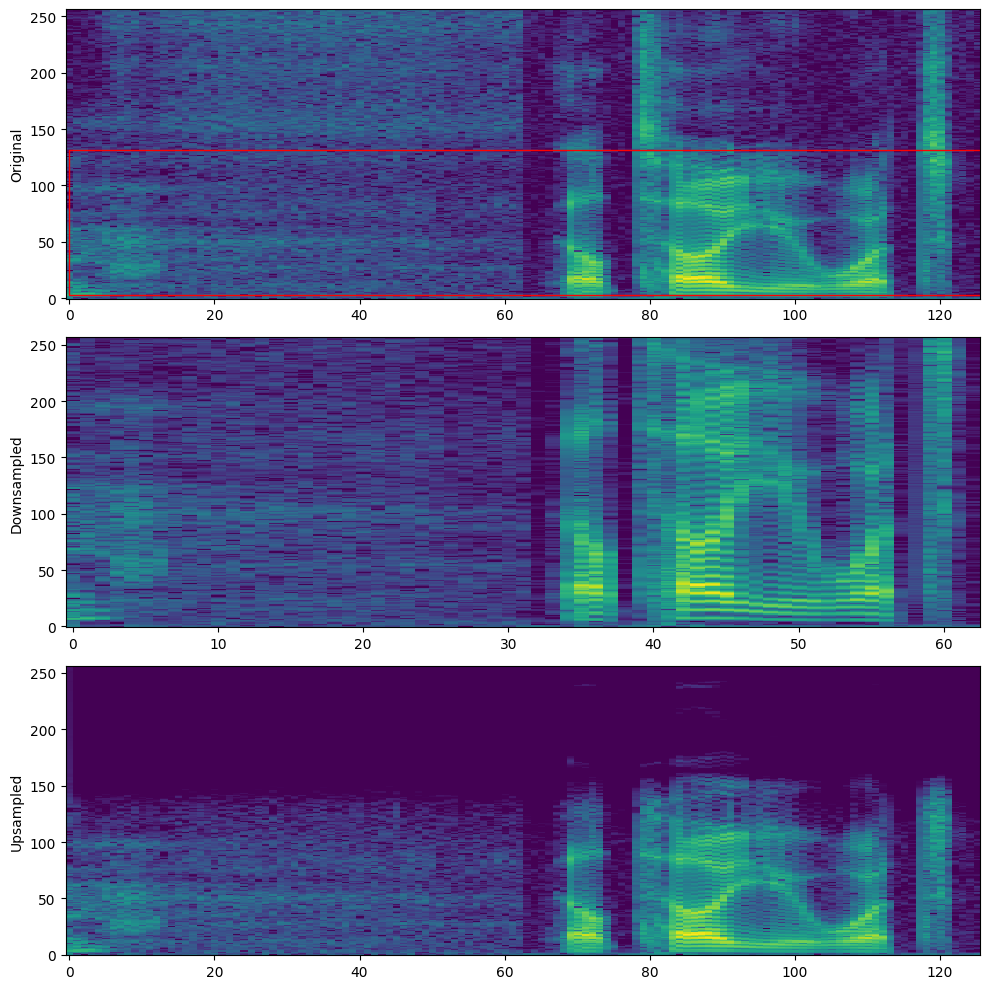

In [15]:
# Visualize it
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# ORIGINAL SPECTOGRAM
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))

# DOWNSAMPLED SPECTOGRAM
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])

# UPSAMPLED SPECTOGRAM
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])

fig.tight_layout()

In the above visualization, the second plot ("Downsampled") might
give the impression that the spectrogram is streched.
This is because the meaning of frequency bins is different from
the original one.
Even though, they have the same number of bins, in the second plot,
the frequency is only covered to the half of the original sampling
rate.
This becomes more clear if we resample the downsampled signal again
so that it has the same sample rate as the original.



## GriffinLim

It is used to recover a waveform from a spectrogram.

The same set of parameters used for spectrogram must be implemented.



In [16]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM_SPLICING)
reconstructed_waveform = griffin_lim(spec)

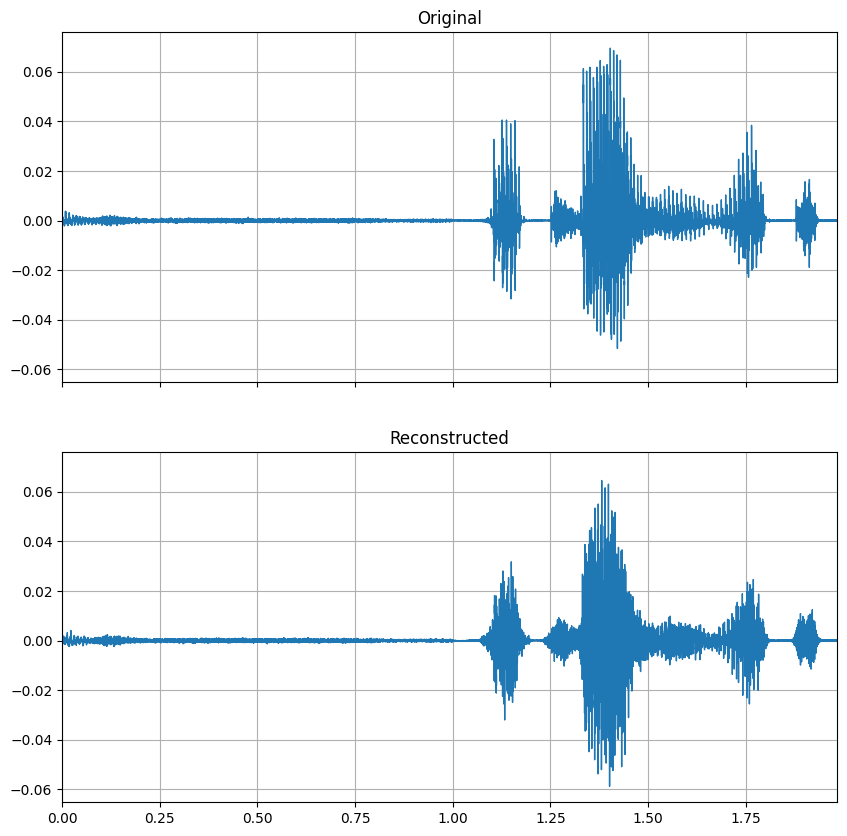

In [17]:
_, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE_SPLICING, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=SAMPLE_RATE_SPLICING)

## Mel Filter Bank

Generates the filter bank
for converting frequency bins to mel-scale bins.

Since this function does not require input audio/features, there is no
equivalent transform.




In [18]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

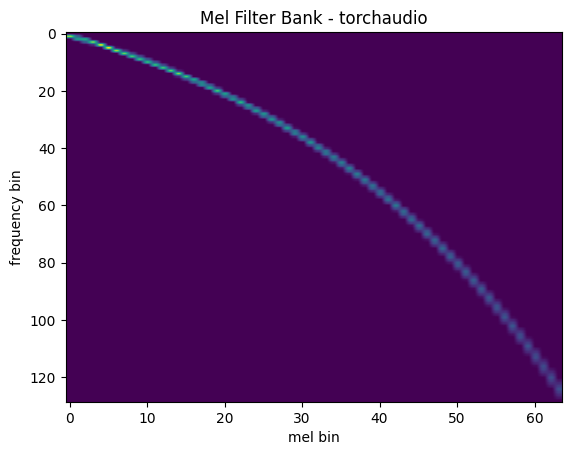

In [19]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

### Comparison against librosa

For reference, here is the equivalent way to get the mel filter bank
with ``librosa``.




In [20]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

Mean Square Difference:  3.924735763781171e-17


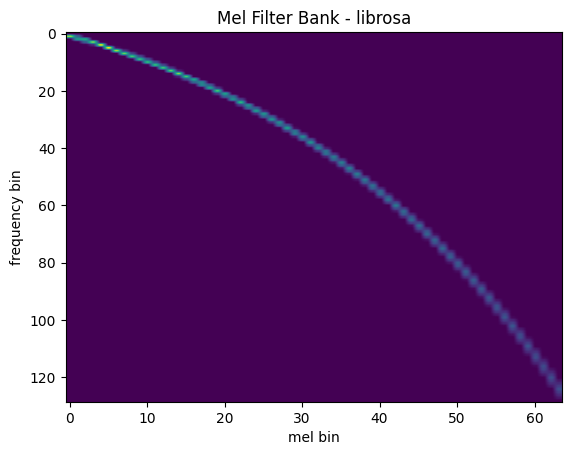

In [21]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MelSpectrogram

Generating a mel-scale spectrogram involves generating a spectrogram
and performing mel-scale conversion. In ``torchaudio``,
:py:func:`torchaudio.transforms.MelSpectrogram` provides
this functionality.




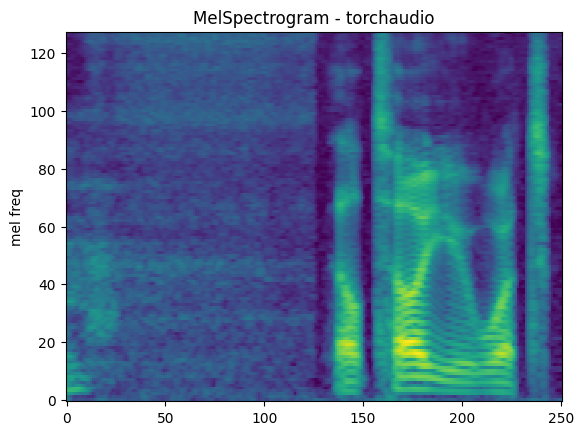

In [22]:
n_fft = 1024
win_length = None
hop_length = 128
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM_SPLICING)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

### Comparison against librosa

For reference, here is the equivalent means of generating mel-scale
spectrograms with ``librosa``.




In [23]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM_SPLICING.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

Mean Square Difference:  1.5600640964068442e-14


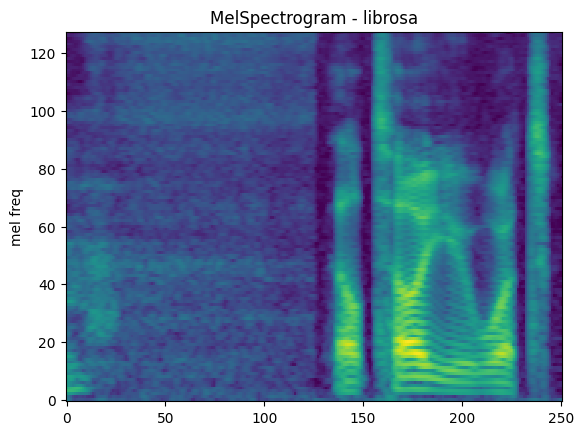

In [24]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MFCC




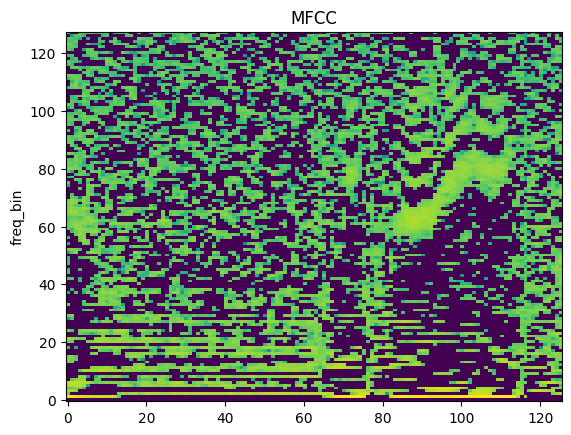

In [25]:
n_fft = 1024
win_length = None
hop_length = 256
n_mels = 128
n_mfcc = 128

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM_SPLICING)
plot_spectrogram(mfcc[0], title="MFCC")

### Comparison against librosa




In [26]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM_SPLICING.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

Mean Square Difference:  0.23318614065647125


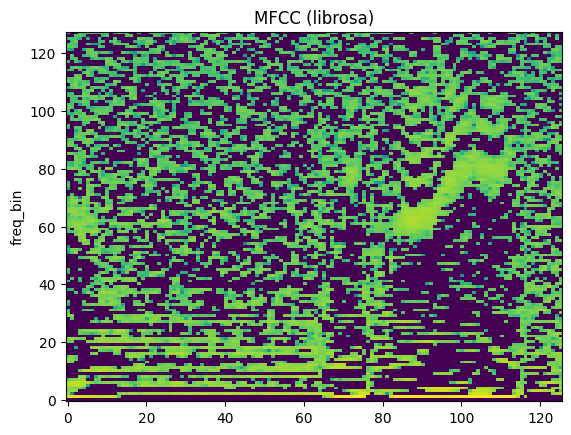

In [27]:
plot_spectrogram(mfcc_librosa, title="MFCC (librosa)")

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

Comparison changing the value of ``n_mfccs``

In [28]:
specs = []

n_fft = 1024
win_length = None
hop_length = 128
mfccs = [64, 128, 256, 512]
# MFCC (Mel-frequency cepstral coefficients) relies on Mel spectrogram computation, and the number of MFCC coefficients should not exceed the number of Mel bins.

for mfcc in mfccs:
    mfcc_transform_test_n_mel = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": mfcc, # n_mfcc <= n_mels
            "hop_length": hop_length,
            "mel_scale": "htk",
        },
    )
    mfcc_test_n_mel= mfcc_transform_test_n_mel(SPEECH_WAVEFORM_SPLICING)
    specs.append(mfcc_test_n_mel)

c:\Users\rayma\Documents\Proyectos VSCode\GitHub Nestor\DeepLearningForgeryAudioDetection\myenv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


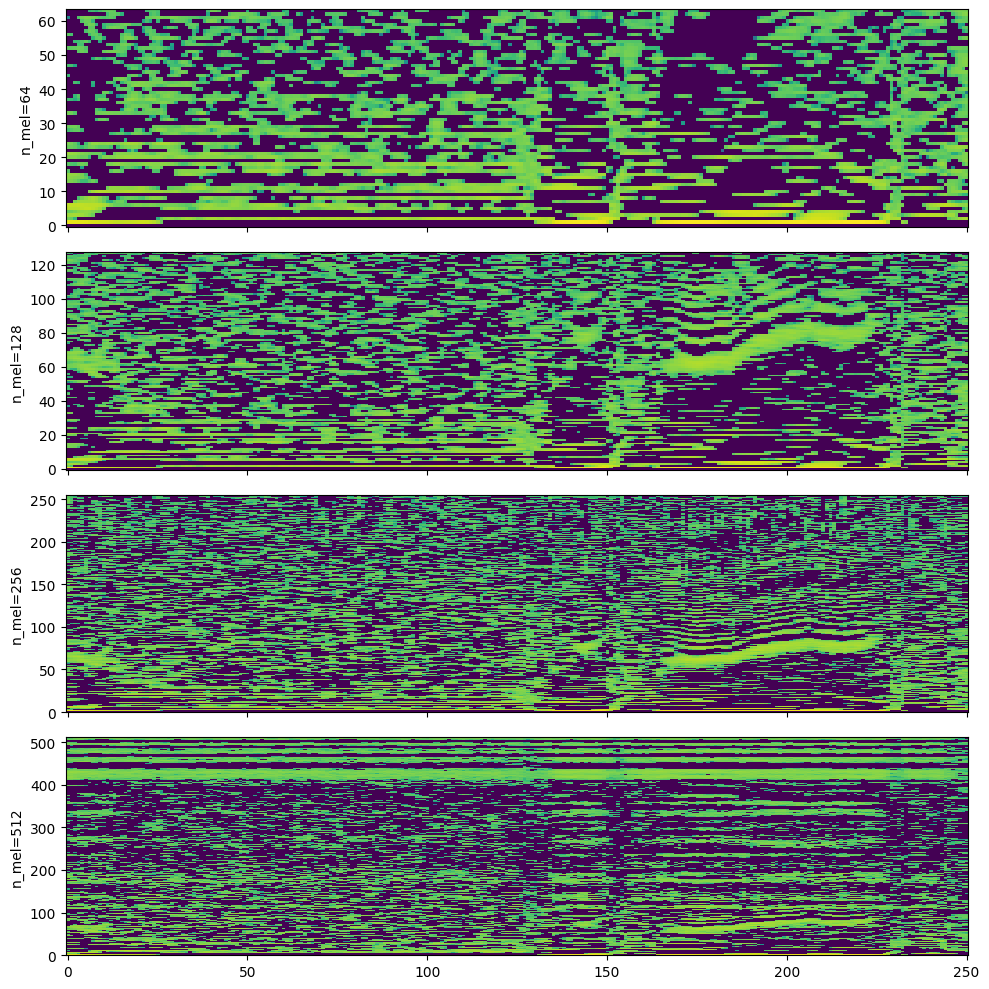

In [29]:
fig, axs = plt.subplots(len(specs), 1, figsize=(10, 10), sharex=True)

for i, (mfcc_test_n_mel, mfcc) in enumerate(zip(specs, mfccs)):
    plot_spectrogram(mfcc_test_n_mel[0], ylabel=f"n_mel={mfcc}", ax=axs[i])
    axs[i].set_xlabel(None)
    
fig.tight_layout()

## LFCC




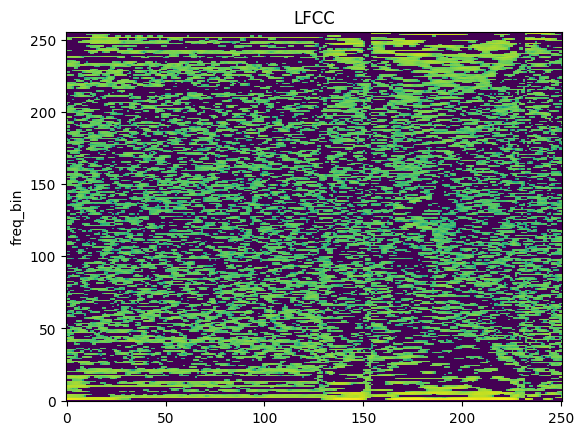

In [30]:
n_fft = 1024
win_length = None
hop_length = 128
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM_SPLICING)
plot_spectrogram(lfcc[0], title="LFCC")

## Pitch




In [31]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING)

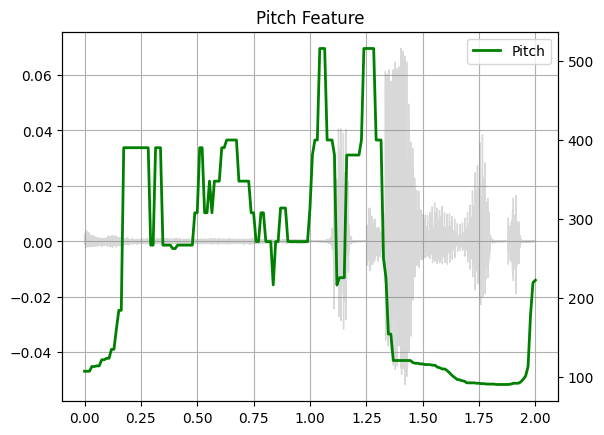

In [32]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(SPEECH_WAVEFORM_SPLICING, SAMPLE_RATE_SPLICING, pitch)

## Spectogram Augmentation

``SpecAugment``: data augmentation technique for spectrograms. 

It applies frequency and time masks to the spectrogram to avoid overfitting and help the model generalize better. 
the model to generalize better. This data augmentation process helps to improve the performance and generalizability of the spectrogram. 
performance and generalization capability of convolutional neural network models trained on audio data. 
trained on audio data.

In [33]:
# Maximum percentage of the spectrogram to mask
max_mask_pct = 0.05

# Number of frequency masks to apply
n_freq_masks = 3

#Number of time masks to apply
n_time_masks = 3


melspec_masking = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM_SPLICING.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

melspec_masking_tensor = torch.tensor(melspec_masking)
melspec_masking_tensor_augmented = melspec_masking_tensor

# Apply frequency masking
freq_mask_param = int(max_mask_pct * melspec_masking_tensor.shape[1])
for _ in range(n_freq_masks):
    melspec_masking_tensor_augmented = torchaudio.transforms.FrequencyMasking(freq_mask_param)(melspec_masking_tensor_augmented)

# Apply time masking
time_mask_param = int(max_mask_pct * melspec_masking_tensor.shape[1])
for _ in range(n_time_masks):
    melspec_masking_tensor_augmented = torchaudio.transforms.TimeMasking(time_mask_param)(melspec_masking_tensor_augmented)

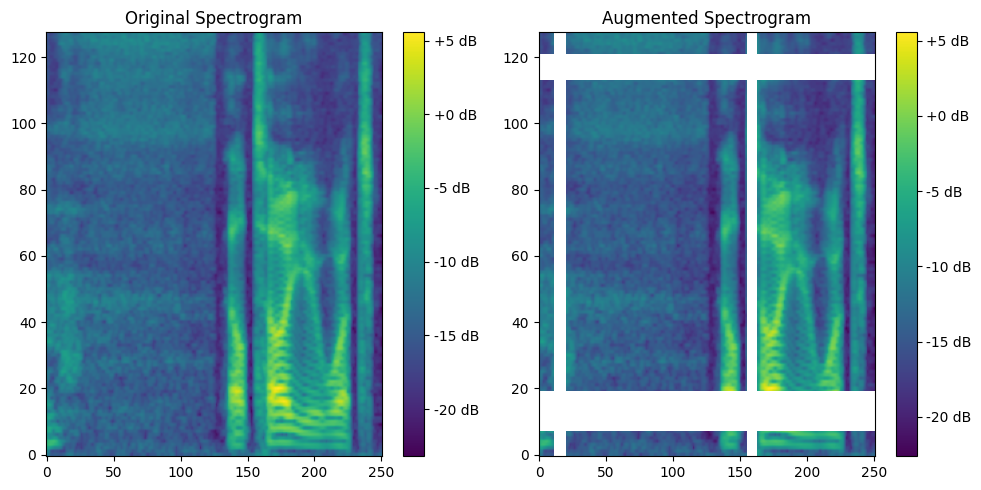

In [34]:
# Original spectrogram
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(melspec_masking_tensor.log2().numpy(), aspect='auto', origin='lower')
plt.title('Original Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Augmented spectrogram
plt.subplot(1, 2, 2)
plt.imshow(melspec_masking_tensor_augmented.log2().numpy(), aspect='auto', origin='lower')
plt.title('Augmented Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()